# Tutorial On Fitting LIGO Catalogs with Selection Effects

Produced for GW group meeting on 2025-05-14.  Our goal here is to fit Gaussian models to the distribution of the $\chi_\mathrm{eff}$ parameters of the LIGO GWTC-3 catalog, ultimately fitting a model that is very similar to the [Callister, et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...922L...5C/abstract) "Who Ordered That" paper that found a correlation between the mean of $\chi_\mathrm{eff}$ and $q$.  We will have to deal with the fact that $\chi_\mathrm{eff}$ comes with some significant measurement uncertainty for each event, and also that the selection function is not uniform across $\chi_\mathrm{eff}$ space (events with high $\chi_\mathrm{eff}$ are more likely to be detected than those with low $\chi_\mathrm{eff}$).  We will build up from simple models to the final complex model.

Some resources that go into fitting populations with selection effects:

* DFM's [blog post](https://dfm.io/posts/histogram1/) explaining why the traditional "upweight by the inverse of the selection function" approach is very wrong.
* [Mandel, Farr, & Gair (2018)](https://arxiv.org/abs/1809.02063) paper going through the formalism for this kind of analysis (which we will follow here).  For pedants (like me!), Section 4 derives the likelihood we are using from first principles.
* [Vitale, et al. (2020)](https://arxiv.org/abs/2007.05579) which is a book chapter that goes through this formalism more pedagogically.
* [Loredo (2004)](https://arxiv.org/abs/astro-ph/0409387), which derived these results in another context.
* [NBI Copenhagen Summer School](https://github.com/farr/GWDataAnalysisSummerSchool) lectures I gave in 2017 (lecture 3 is on this topic, with yet another example). 
* [Tom Callister's](https://tcallister.github.io/gallery.html) demo of hierarchical inference, [here](https://github.com/gw-gallery/hierarchical-inference-demo), which gives a lot of intuition about this sort of inference.
* My [PopModels.jl](https://github.com/farr/PopModels.jl) package automates a lot of this model building---you supply the population model, it computes the likelihood terms, and even a normalized rate (not discussed here), draws detectable samples from the population model, and more.

In [1]:
# Comes first so that the interpreter automatically tracks updates to the files that define our modules.
using Revise

using ArviZ
using CairoMakie
using DataFrames
using HDF5
using LaTeXStrings
using ProgressLogging
using SelectionTutorial
using Statistics
using StatsFuns
using Turing

The LIGO PE samples and sensitivity data file, which you can download from:

* GWTC-2: https://zenodo.org/records/6513631
* GWTC-3: https://zenodo.org/records/8177023
* Search Sensitivity: https://zenodo.org/records/7890398

In [2]:
gwtc_2_dir = "/Users/wfarr/Research/gwtc-2.1"
gwtc_3_dir = "/Users/wfarr/Research/o3b_data/PE"
sensitivity_file = "/Users/wfarr/Research/o3b_data/O1O2O3-Sensitivity/o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5";

Let's load up the samples, and reject any events that have $m_2 < 3 \, M_\odot$.  (Note that here we are including events from GWTC-2.1, the marginal / sub-threshold sample, but below we will impose a selection cut at $\mathrm{FAR} < 1 / \mathrm{yr}$.  This is marginally inconsistent, and could be fixed by cutting out the marginal events from GWTC-2.1, but for now we will ignore that complication.)

In [3]:
gwtc_2_pe = load_pe_from_dir(gwtc_2_dir)
gwtc_3_pe = load_pe_from_dir(gwtc_3_dir)

all_pe = vcat(gwtc_2_pe, gwtc_3_pe; cols=:intersect)

# Now we cut out only the binary black hole events:
bbh_events = vcat([e for e in groupby(all_pe, :gwname) if all(e[!, :mass_2_source] .> 3)]...; cols=:intersect)

nevt = length(groupby(bbh_events, :gwname))
@info "Number of BBH events: $nevt, out of $(length(groupby(all_pe, :gwname))) total events"

┌ Info: Could not read IGWN-GWTC2p1-v2-GW190425_081805_PEDataRelease_mixed_nocosmo.h5
└ @ SelectionTutorial /Users/wfarr/Teaching/SelectionTutorial/src/SelectionTutorial.jl:61
┌ Info: Number of BBH events: 65, out of 89 total events
└ @ Main /Users/wfarr/Teaching/SelectionTutorial/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sZmlsZQ==.jl:10


Let's have a look at the posterior on $\chi_\mathrm{eff}$ for all the events in the catalog:

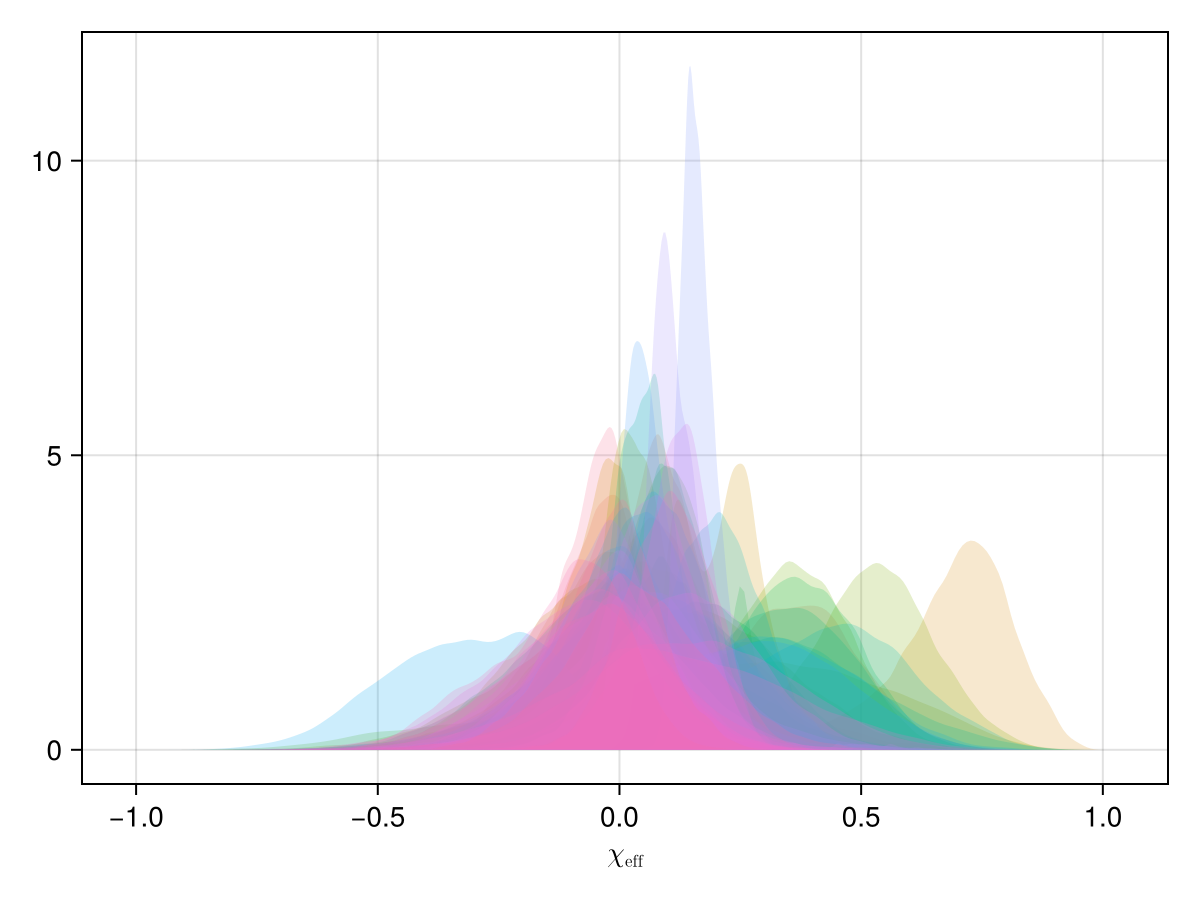

In [4]:
cs = categorical_palette(nevt)

f = Figure()
a = Axis(f[1,1], xlabel=L"\chi_\mathrm{eff}")

for (i, evt) in enumerate(groupby(bbh_events, :gwname))
    density!(a, evt[!, :chi_eff], color=(cs[i], 0.2)) # color and alpha = 0.2
end

f

From looking at this plot, it seeems like:

1. The observational uncertainties are significant (that is: a lot of the scatter from event to event is comparable to the width of the distribution).
2. There may be more events with positive $\chi_\mathrm{eff}$ than negative $\chi_\mathrm{eff}$.

The distribution of uncertainties will impose a fundamental limit in how well we could "resolve" features of the $\chi_\mathrm{eff}$ distribution.  One (conservative) estimate of the resolution of this data set is to imagine that the uncertainties were Gaussian, and the underlying distribution was a delta-function in $\chi_\mathrm{eff}$; then the uncertainty in the location of the delta-function peak would be given by 
$$
\sigma = \left( \sum_i \frac{1}{\mathrm{var} \, \chi_{\mathrm{eff},i}} \right)^{-1/2}
$$

Turns out that resolution is pretty fine: ~0.01 in $\chi_\mathrm{eff}$:

In [5]:
resolution = 1/sqrt(sum([1/var(df[!,:chi_eff]) for df in groupby(bbh_events, :gwname)]))
@info "Resolution: $resolution"

┌ Info: Resolution: 0.01413210594769037
└ @ Main /Users/wfarr/Teaching/SelectionTutorial/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X34sZmlsZQ==.jl:2


Let's try to fit a Gaussian model to the underlying distribution of $\chi_\mathrm{eff}$ from these PE samples (for now we will ignore selection effects, see below).  There is a complicated: PE samples come from a combination of a prior on the parameters and a likelihood function that encodes the measurement of parameters from the detector's data.  We want to *remove* the PE prior, and impose our own population prior.  You can look up the PE priors in Tom Callister's helpful "[A Thesaurus for Common Priors in Gravitational-Wave Astronomy](https://arxiv.org/abs/2104.09508)" (or you could read the various papers describing the catalog); I've coded up the default pe prior in the associated `SelectionTutorial.jl` module.

In math: a hierarchical population model like this specifies a population distribution for the effective spin, here a Gaussian with mean $\mu$ and standard deviation $\sigma$, **as well as all the other parameters** and then uses the likelihood function for each observation to weight the possible (latent, that is, unobserved) values of $\chi_\mathrm{eff}$ and the other parameters by the likelihood of observing the data given that value.  The joint posterior over parameters $\theta = \left( m_1, m_2, \chi_\mathrm{eff}, z, \ldots\right)$ and population variables $\lambda = \left( \mu, \sigma \right)$ is
$$
p\left( \lambda, \left\{\theta_i\right\} \mid \left\{ d_i \right\} \right) \propto p\left( \lambda \right) \prod_i p\left( d_i \mid \theta_i \right) p\left( \theta_i \mid \lambda \right),
$$
where $p\left( \theta \mid \lambda \right)$ is the population distribution for all the parameters that go into the likelihood. For parameters that **aren't** $\chi_\mathrm{eff}$ we will make up a reasonable population with no parameters (i.e. a "fixed" population), see below.  The only parameters that we are going to fit are $\mu$ and $\sigma$, which are the mean and standard deviation of the Gaussian population distribution for $\chi_\mathrm{eff}$, so these other distributional componets can be treated as a constant over $\lambda$.

It's usually convenient to integrate out the latent parameters $\theta_i$ for each event (we can later put them back in if we want to), which produces the \emph{marginal} posterior for $\lambda$ given the catalog data:
$$
p\left( \lambda \mid \left\{ d_i \right\}\right) \propto p\left( \lambda \right) \prod_i p\left( d_i \mid \lambda \right) = p\left( \lambda \right) \prod_i \int p\left( d_i \mid \theta_i \right) p\left( \theta_i \mid \lambda \right) \, \mathrm{d}\theta_i.
$$
We can insert and remove a factor of the PE prior, and obtain 
$$
p\left( \lambda \mid \left\{ d_i \right\}\right) \propto p\left( \lambda \right) \prod_i \int p\left( d_i \mid \theta_i \right) p_\mathrm{PE}\left( \theta_i \right) \frac{p\left( \theta_i \mid \lambda \right)}{p_\mathrm{PE}\left( \theta_i \right)} \, \mathrm{d}\theta_i \simeq p\left( \lambda \right) \prod_i \left\langle \frac{p\left( \theta_i \mid \lambda \right)}{p_\mathrm{PE}\left( \theta_i \right)} \right\rangle_{\theta_i \sim \mathrm{PE}_i}.
$$
Marginalizing over the latent (true) parameters for each event corresponds to averaging the ratio of the population to the PE prior over the PE samples for each event.  

The PE prior specifies a density over all 15 parameters for each event; if we wanted to, we could define a 15-dimensional population distribution, and take the ratio.  However, here we are going to just be interested in the population over $\chi_\mathrm{eff}$.  We will specify a simple, default population model for the mass and mass ratio, that is a power law in the primary mass, and flat in the mass ratio,
$$
p\left( m_1, q \right) \propto m_1^{-2.35},
$$
and impose a merger rate in the comoving frame that follows the Madau-Dickinson star formation shape:
$$
p\left( z \right) \propto \frac{\left( 1+z \right)^{2.7}}{1 + \left( \frac{1 + z}{2.9} \right)^{5.6}} \frac{\mathrm{d} V}{\mathrm{d} z} \frac{1}{1+z},
$$
where the latter two factors convert from comoving time-volume to redshift and detector frame time (again, see Tom's thesaurus).  

The only factor that varies with $\lambda$ is the Gaussian term for $\chi_\mathrm{eff}$ in the population:
$$
p\left( \chi_\mathrm{eff} \mid \lambda \right) \propto \frac{1}{\sigma\sqrt{2 \pi}} \exp\left( -\frac{\left( \chi_\mathrm{eff} - \mu \right)^2}{2 \sigma^2} \right).
$$

Below we build a Turing model that fits the 2D distribution of $\mu$ and $\sigma$ fitted to these data:

In [6]:
Nmcmc = 1000

# First we add some columns to the dataframe that store the PE weights and the default pop weights:
bbh_events[!, :pe_logwt_m1qzchie] = li_nocosmo_prior_logwt_m1qzchie(bbh_events)
bbh_events[!, :pop_logwt_m1qz] = pop_logwt_m1qz(bbh_events)

# We only need 128 samples from each event (this will make our analysis run
# faster); you can check if you are using enough samples by evaluating the
# variance of the estimate of the mean weight.  See Essick & Farr (2022) or
# Talbot & Golomb (2023) for more information.
Nsamp = 128
bbh_df = vcat([df[rand(1:size(df,1), Nsamp), :] for df in groupby(bbh_events, :gwname)]...; cols=:intersect)

@model function gaussian_pop_noselection(df)
    mu ~ Normal(0,1) # Pretty broad prior on the mean of the distribution
    sigma ~ Exponential(1) # Pretty broad prior on the standard deviation of the distribution

    popdist = Normal(mu, sigma)

    for evt in groupby(df, :gwname)
        log_wt = logpdf.((popdist,), evt[!, :chi_eff]) .+ evt[!, :pop_logwt_m1qz] .- evt[!, :pe_logwt_m1qzchie]
        @Turing.addlogprob! logsumexp(log_wt) # log(sum(exp(log_wt)))
    end
end

gp_nosel_model = gaussian_pop_noselection(bbh_df)
gp_noselection_trace = sample(gp_nosel_model, NUTS(Nmcmc, 0.65), Nmcmc)
gp_noselection_trace = from_mcmcchains(gp_noselection_trace) # Convert to ArviZ object

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/wfarr/.julia/packages/Turing/nQwbh/src/mcmc/hmc.jl:207
Sampling   0%|▎                                         |  ETA: 0:14:51
Sampling   1%|▍                                         |  ETA: 0:07:35
Sampling   2%|▋                                         |  ETA: 0:05:12
Sampling   2%|▉                                         |  ETA: 0:03:56
Sampling   2%|█                                         |  ETA: 0:03:12
Sampling   3%|█▎                                        |  ETA: 0:02:42
Sampling   4%|█▌                                        |  ETA: 0:02:20
Sampling   4%|█▋                                        |  ETA: 0:02:03
Sampling   4%|█▉                                        |  ETA: 0:01:50
Sampling   5%|██▏                                       |  ETA: 0:01:40
Sampling   6%|██▎                                       |  ETA: 0:01:33
Sampling   6%

InferenceData with groups:
  > posterior
  > sample_stats

We can plot the trace:

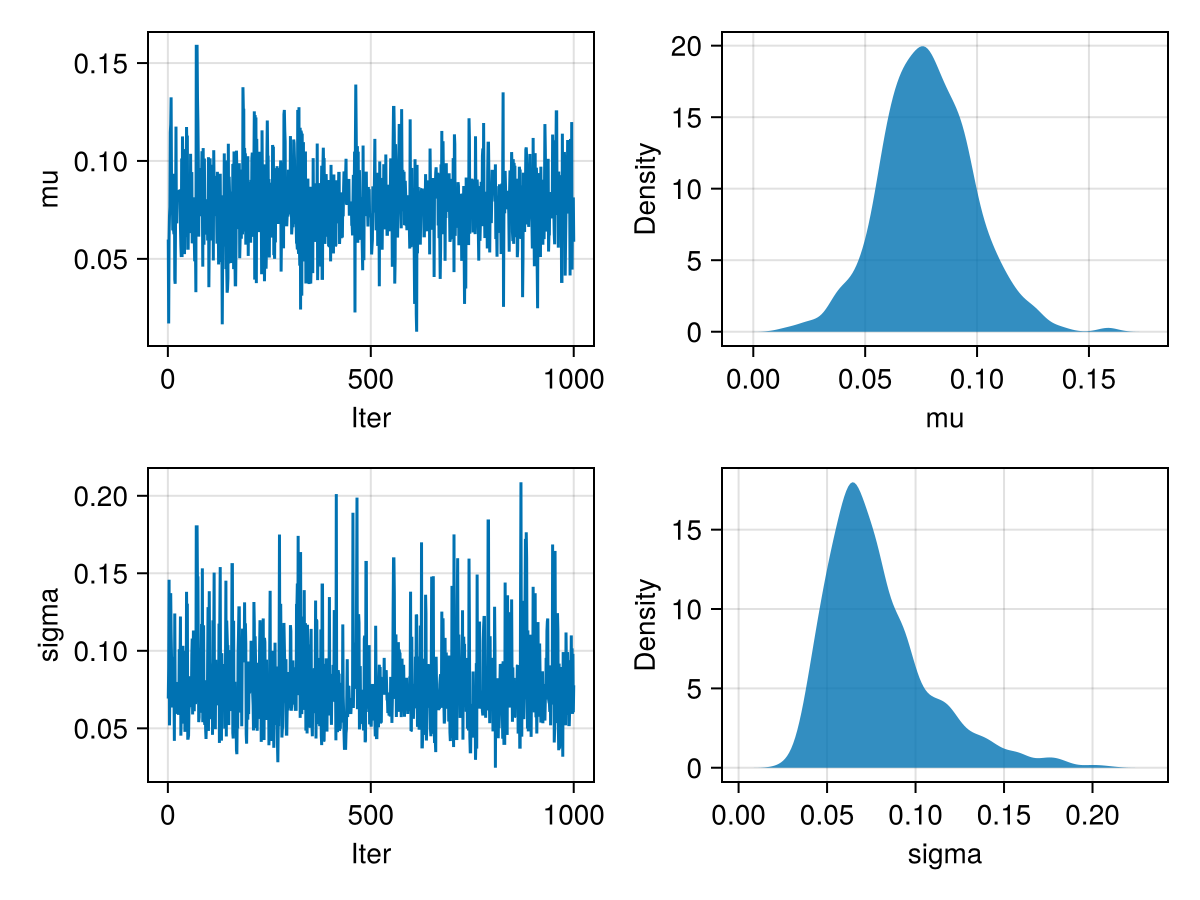

In [7]:
SelectionTutorial.traceplot(gp_noselection_trace, [:mu, :sigma])

Or we can plot posterior contours:

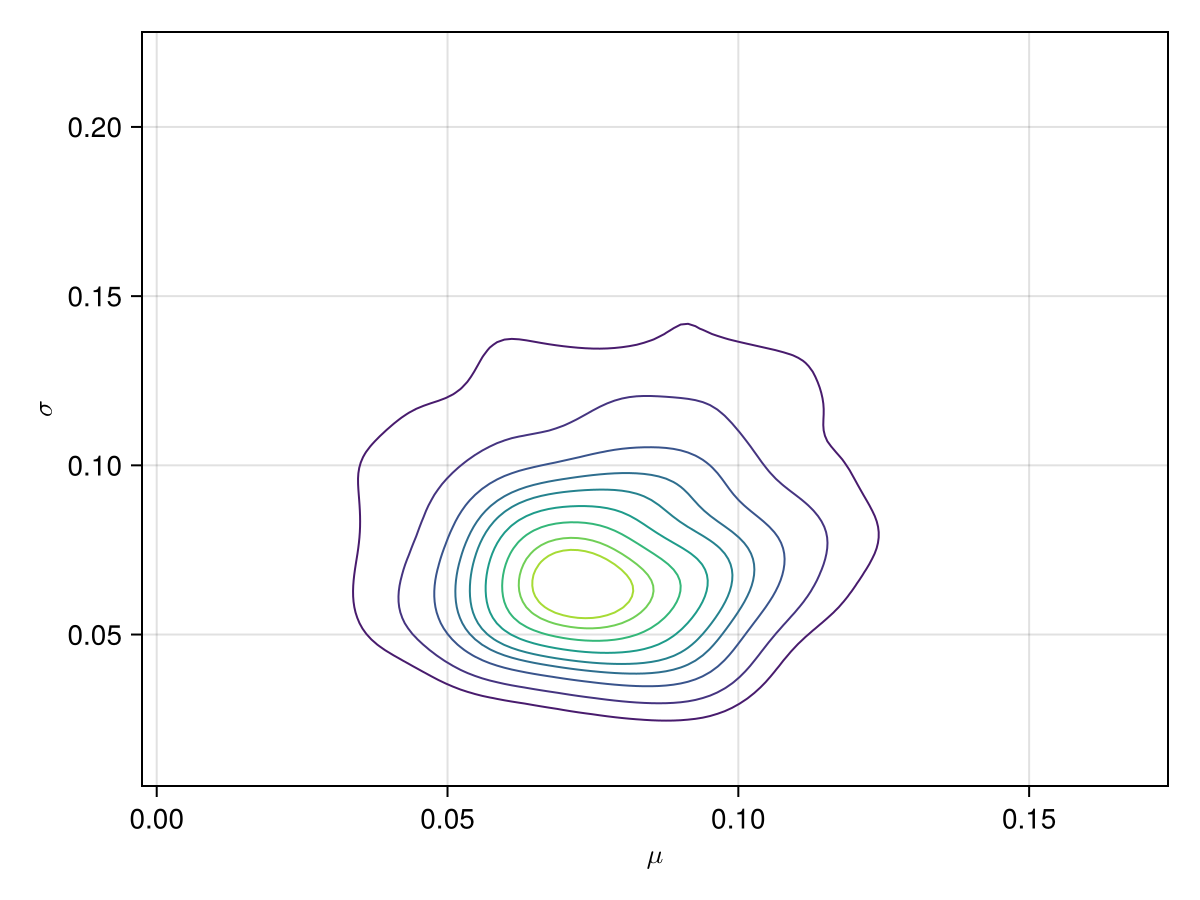

In [8]:
f = Figure()
a = Axis(f[1,1], xlabel=L"\mu", ylabel=L"\sigma")
kdecontour!(a, vec(gp_noselection_trace.posterior.mu), vec(gp_noselection_trace.posterior.sigma), levels=0.1 .* (1:9))
f

As we saw above, there seems to be a preference for positive $\chi_\mathrm{eff}$ ($\mu > 0$), and also there is a measurable, finite width to the $\chi_\mathrm{eff}$ distribution.

But!  We ignored that our catalog does not represent a random draw from the population distribution, but rather a random draw from the population distribution *that produces detectable signals in LIGO*!  In other words, there are selection effects that could be causing the features we see above.  Happily, LIGO provides data products to quantify the effect of selection on the parameters of the catalog.  Basically, LIGO generates a bunch of waveforms whose parameters are drawn from a fiducial (and known) population, injects them into the LIGO data stream, and then recovers them using the same pipelines that detect catalog events.  We record the injections that have any reasonable FAR from the pipelines in a file, the `sensitivity_file` above.  By adjusting the weight assigned to each injection, you can determine the fraction of any population that would appear in our catalog.

To get a sense of whether we should expect more detections with positive $\chi_\mathrm{eff}$ than negative $\chi_\mathrm{eff}$, we can look at the distribution of the $\chi_\mathrm{eff}$ values from the sensitivity file, which records synthetic injections into the LIGO data stream, detected by the actual pipelines.  We load all the injections from the sensitivity file, and select the ones that were detected at $\mathrm{FAR} < 1 / \mathrm{yr}$ by at least one pipeline; as mentioned above, this almost (but not quite, due to GWTC-2.1 marginal events) matches the selection function used to compile the catalog.  We could fix things up by examining the table of FARs at [GWOSC](https://gwosc.org/eventapi/html/GWTC/) and removing the events that don't pass this cut from our data frame.

In [5]:
all_injections, T_yr, Ndraw = load_selection(sensitivity_file) # T_yr and Ndraw would be needed to obtain a normalized rate statement, but here we are only interested in the *shape* of the population

ifar_thresh = 1.0 # FAR < 1 / yr
detected = zeros(Bool, size(all_injections, 1))
for pipeline in ["pycbc_hyperbank", "gstlal", "mbta", "cwb", "pycbc_bbh"]
    detected .= detected .|| (all_injections[!, Symbol("ifar_", pipeline)] .> ifar_thresh)
end

detected_injections = all_injections[detected, :]

36468×35 DataFrame
   Row │ far_cwb        far_gstlal      far_mbta       far_pycbc_bbh   far_pyc ⋯
       │ Float64        Float64         Float64        Float64         Float64 ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │   0.000972078     1.1951e-26     5.96879e-6      2.00025e-5           ⋯
     2 │ Inf               5.5743e-12    11.7656          7.76431e-5
     3 │   0.259545        0.000439613    0.10241         0.000400049
     4 │   0.000894936     2.67259e-27    1.32216e-11     6.00974e-5
     5 │   0.601999        1.08183e-11   10.0717          6.00974e-5           ⋯
     6 │ Inf               0.0014405    Inf            8829.3                I
     7 │ Inf               0.524567       2.80279         0.210081
     8 │   0.000818412     1.44639e-19    0.0248832       8.37162e-5
   ⋮   │       ⋮              ⋮               ⋮              ⋮                 ⋱
 36462 │ Inf              10.8883         0.656265      Inf                  I ⋯
 36463 │ Inf               6.0824e-9      0.254648        0.0119007          I
 36464 │   3.15263         0.00140825   245.611           1.08915            4
 36465 │ Inf            1188.97           0.108573        0.00924706
 36466 │ Inf               1.91774e-7     0.396474        0.000707551          ⋯
 36467 │ Inf               1.65667e-7   660.317           0.80284            I
 36468 │ Inf               0.000929635  Inf             Inf                  I
                                               31 columns and 36453 rows omitted

And we can see that there is a very small preference for positive $\chi_\mathrm{eff}$ values among the detected injections (in fact, $\left\langle \chi_\mathrm{eff} \right\rangle = 0.05$).

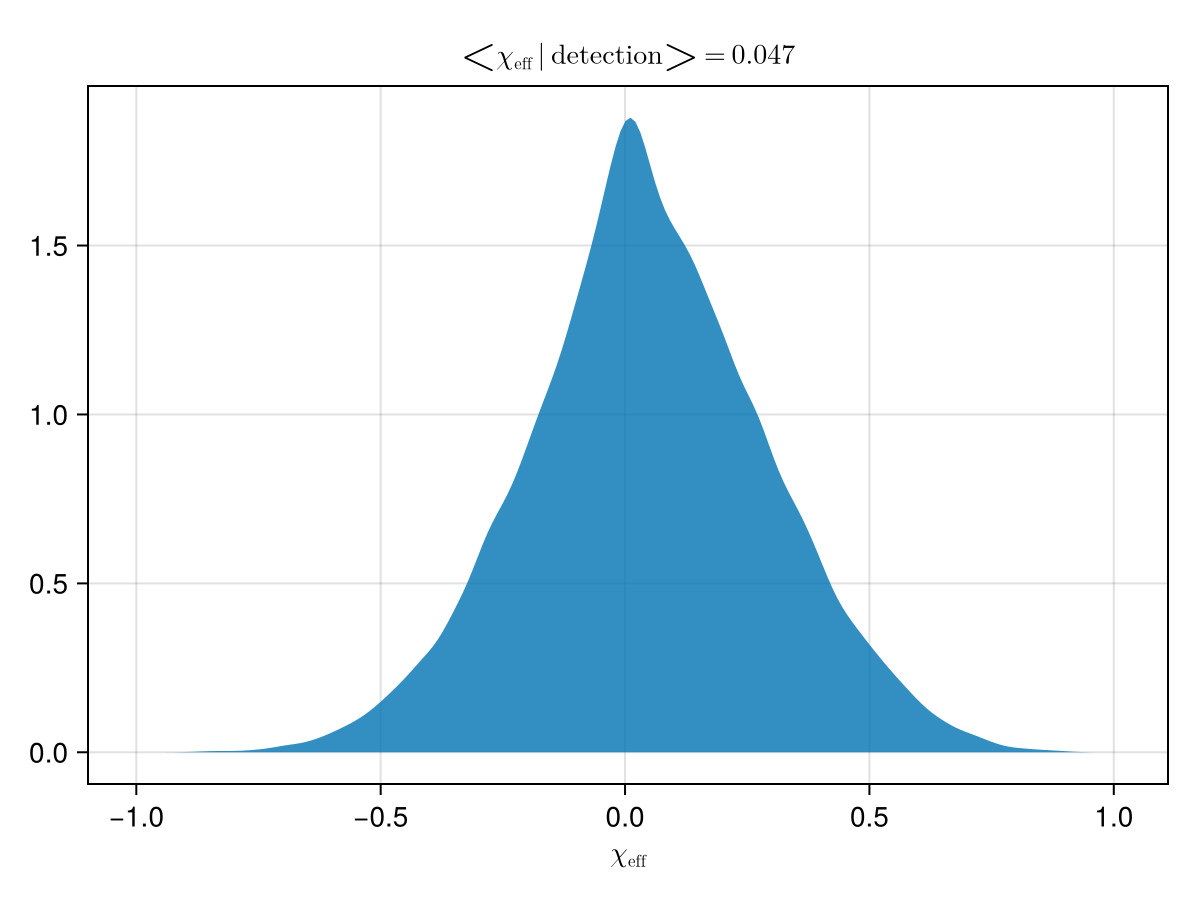

In [10]:
m = mean(detected_injections[!, :chi_eff])

f = Figure()
a = Axis(f[1,1], xlabel=L"\chi_\mathrm{eff}", title=L"$\left< \chi_\mathrm{eff} \mid \mathrm{detection} \right> = %$(round(m, digits=3))$")
density!(a, detected_injections[!, :chi_eff])
f

This is concerning, because the mean $\chi_\mathrm{eff}$ we found from ignoring selection effects above is about the same as this mean---so are we just seeing the selection effect?

[Mandel, Farr, & Gair (2019)](https://arxiv.org/abs/1809.02063) shows that the way to correct selection effects in to re-normalize the population distribution by the fraction of the population that is detectable.  Note that we **do not** adjust the weights we apply to the latent parameters for each event in the catalog---we **do not** fit the "detectable population" to the observed data.  This is a subtle point!  We do not do this because detectability is a property of the **data**, not the latent parameters of each event; so the fact that GW150914 appears in our catalog does not depend on the latent parameters that we assign to it---so we should not modify the weights we assign them in the fit.  A good intuitive explanation of this can be found in this DFM [blog post](https://dfm.io/posts/histogram1/).

So, the likelihood above becomes 
$$
p\left( \lambda \mid \left\{ d_i \right\}\right) \propto p\left( \lambda \right) \prod_i \frac{1}{\alpha\left( \lambda \right)} \int p\left( d_i \mid \theta_i \right) p_\mathrm{PE}\left( \theta_i \right) \frac{p\left( \theta_i \mid \lambda \right)}{p_\mathrm{PE}\left( \theta_i \right)} \, \mathrm{d}\theta_i \simeq p\left( \lambda \right) \prod_i \frac{1}{\alpha\left( \lambda \right)} \left\langle \frac{p\left( \theta_i \mid \lambda \right)}{p_\mathrm{PE}\left( \theta_i \right)} \right\rangle_{\theta_i \sim \mathrm{PE}_i},
$$
where 
$$
\alpha\left( \lambda \right) = \int P_\mathrm{det}\left( \theta \right) p\left( \theta \mid \lambda \right) \, \mathrm{d}\theta,
$$
with $P_\mathrm{det}\left(\theta \right)$ the probability that an event with parameters $\theta$ would be detected by our pipelines in our data.  Once again, we can insert and remove a factor, this time of the fiducial population from which the sensitivity injections were drawn:
$$
\alpha\left( \lambda \right) = \int P_\mathrm{det}\left( \theta \right) p_\mathrm{draw} \left( \theta \right) \frac{p\left( \theta \mid \lambda \right)}{p_\mathrm{draw} \left( \theta \right)} \, \mathrm{d}\theta \simeq \left\langle \frac{p\left( \theta \mid \lambda \right)}{p_\mathrm{draw} \left( \theta \right)} \right\rangle_{\theta \sim p_\mathrm{draw}, \mathrm{detected}}.
$$
Once again, an integral has become an average over a Monte-Carlo sample parameters (we are being a bit loose here with normalizations; for the full details, see [Farr (2019)](https://arxiv.org/abs/1904.10879)).  As before, the parts of the population distribution over mass and redshift are un-changing, so we pre-compute them, and only include the varying weights over the $\chi_\mathrm{eff}$ population in the model below:


In [11]:
# Add some columns to the detected injections for the constant part of the population (draw weights are already computed; see `load_selection`):
detected_injections[!, :mass_1_source] = detected_injections[!, :mass1_source]
detected_injections[!, :pop_logwt_m1qz] = pop_logwt_m1qz(detected_injections)
detected_injections[!, :log_sampling_pdf_qchieff] = log.(detected_injections[!, :sampling_pdf_qchieff])

Nsamp = 256 # Need a few more samples.
bbh_df = vcat([df[rand(1:size(df,1), Nsamp), :] for df in groupby(bbh_events, :gwname)]...; cols=:intersect)

@model function gaussian_pop(catalog_df, detected_df)
    mu ~ Normal(0, 1) # Pretty broad prior on the mean of the distribution
    sigma ~ Exponential(1) # Pretty broad prior on the standard deviation of the distribution

    popdist = Normal(mu, sigma)

    # Estimate alpha, the selection correction:
    log_alpha_wts = logpdf.((popdist,), detected_df[!, :chi_eff]) .+ detected_df[!, :pop_logwt_m1qz] .- detected_df[!, :log_sampling_pdf_qchieff]
    log_alpha = logsumexp(log_alpha_wts)

    for evt in groupby(catalog_df, :gwname)
        log_wt = logpdf.((popdist,), evt[!, :chi_eff]) .+ evt[!, :pop_logwt_m1qz] .- evt[!, :pe_logwt_m1qzchie]
        @Turing.addlogprob! logsumexp(log_wt) - log_alpha
    end
end

gp_model = gaussian_pop(bbh_df, detected_injections)
gp_trace_mcmcchains = sample(gp_model, NUTS(Nmcmc, 0.65), Nmcmc)
gp_trace = from_mcmcchains(gp_trace_mcmcchains) # Convert to ArviZ object

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.5015625
└ @ Turing.Inference /Users/wfarr/.julia/packages/Turing/nQwbh/src/mcmc/hmc.jl:207
Sampling   0%|▎                                         |  ETA: 0:03:43
Sampling   1%|▍                                         |  ETA: 0:02:09
Sampling   2%|▋                                         |  ETA: 0:01:36
Sampling   2%|▉                                         |  ETA: 0:01:26
Sampling   2%|█                                         |  ETA: 0:01:20
Sampling   3%|█▎                                        |  ETA: 0:01:15
Sampling   4%|█▌                                        |  ETA: 0:01:15
Sampling   4%|█▋                                        |  ETA: 0:01:12
Sampling   4%|█▉                                        |  ETA: 0:01:07
Sampling   5%|██▏                                       |  ETA: 0:01:06
Sampling   6%|██▎                                       |  ETA: 0:01:03
Samplin

InferenceData with groups:
  > posterior
  > sample_stats

We can plot the trace:

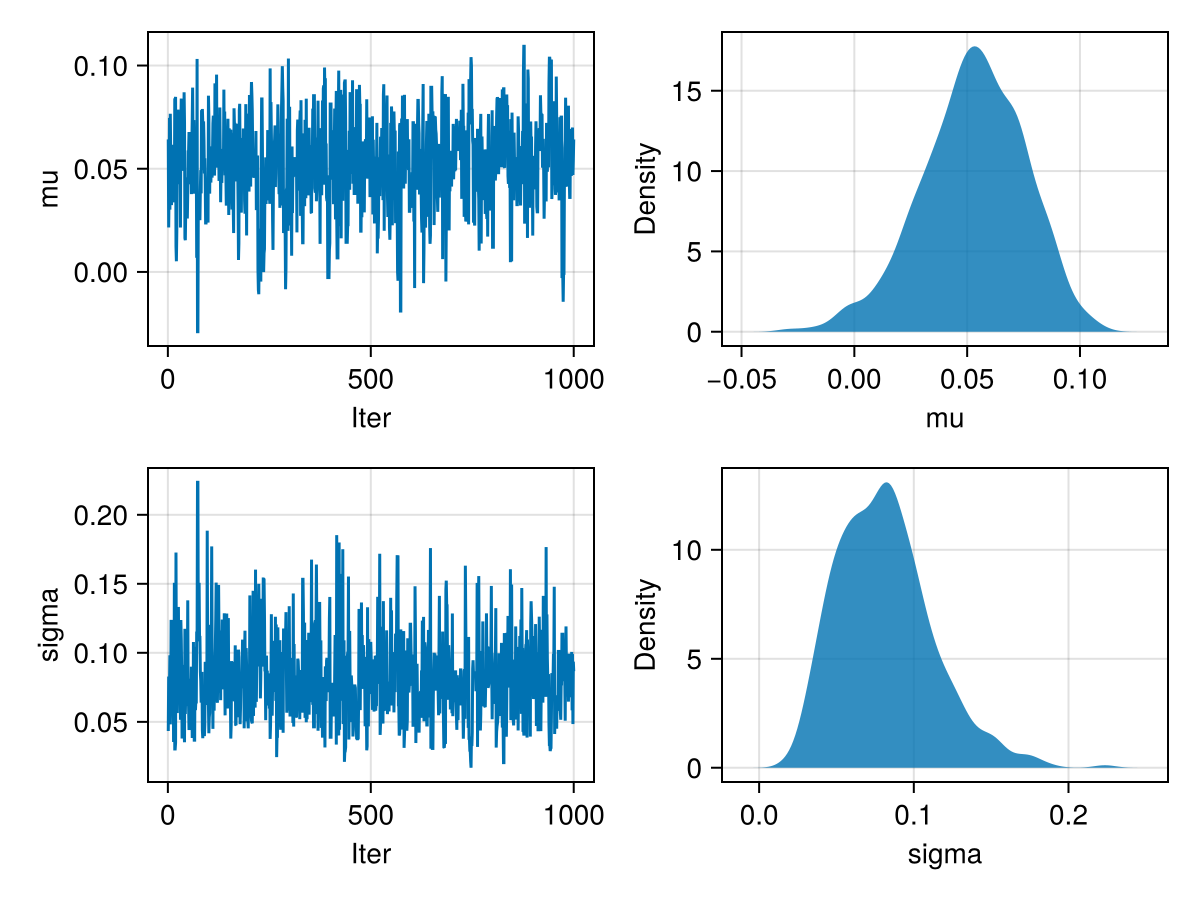

In [12]:
SelectionTutorial.traceplot(gp_trace, [:mu, :sigma])

Or we can plot posterior contours:

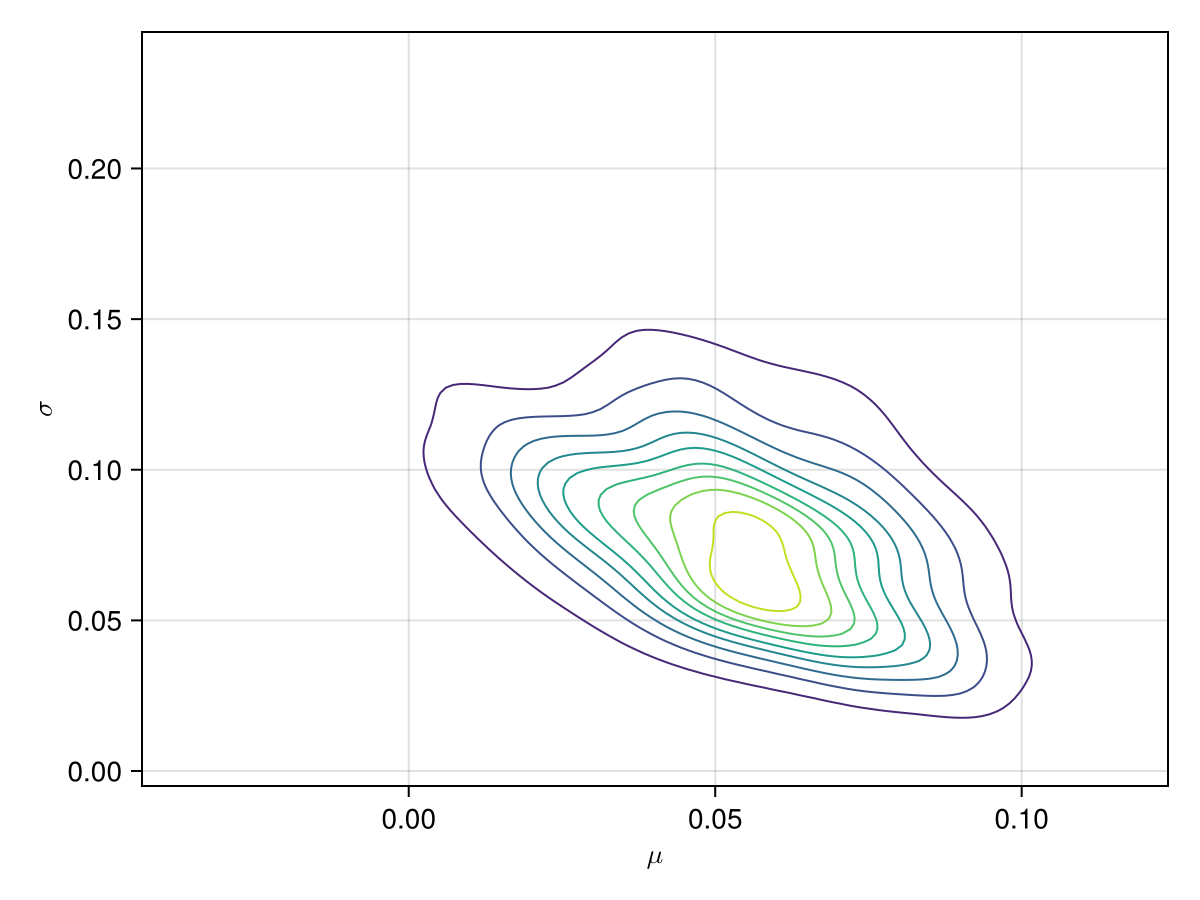

In [13]:
f = Figure()
a = Axis(f[1,1], xlabel=L"\mu", ylabel=L"\sigma")
kdecontour!(a, vec(gp_trace.posterior.mu), vec(gp_trace.posterior.sigma), levels=0.1 .* (1:9))
f

A comparison of the posteriors shows the effect of including selection, which are very weak.  (We could have predicted this, because the inferred population is very narrow---it is hard for selection to change a very narrow population much, since the selection function will be nearly constant over the population; but it is important to check!)

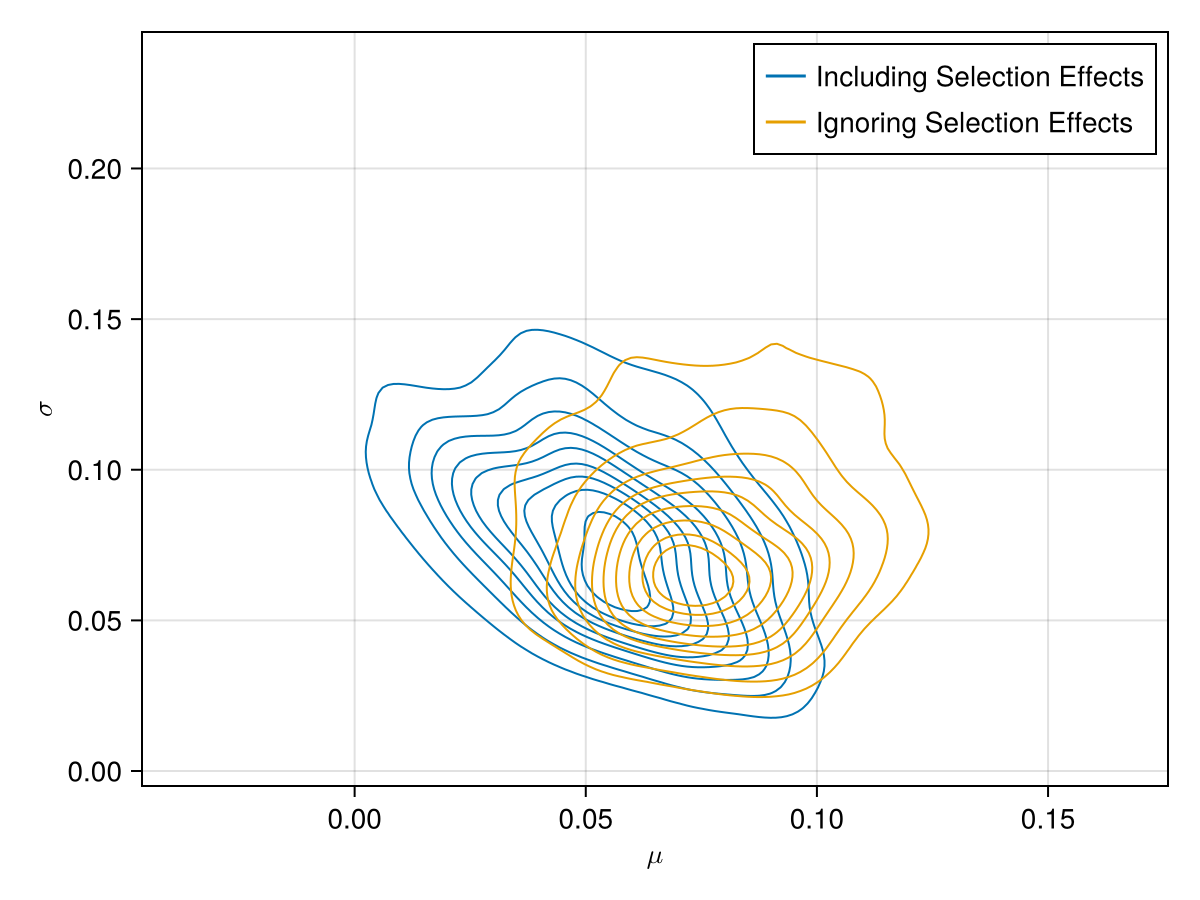

In [14]:
f = Figure()
a = Axis(f[1,1], xlabel=L"\mu", ylabel=L"\sigma")
kdecontour!(a, vec(gp_trace.posterior.mu), vec(gp_trace.posterior.sigma), levels=0.1 .* (1:9), color=Makie.wong_colors()[1], label="Including Selection Effects")
kdecontour!(a, vec(gp_noselection_trace.posterior.mu), vec(gp_noselection_trace.posterior.sigma), levels=0.1 .* (1:9), color=Makie.wong_colors()[2], label="Ignoring Selection Effects")

# For some reason we have to do this manually:
axislegend(a, [LineElement(color=Makie.wong_colors()[1]), LineElement(color=Makie.wong_colors()[2])], ["Including Selection Effects", "Ignoring Selection Effects"])

f

Let's plot the inferred population over the observations:

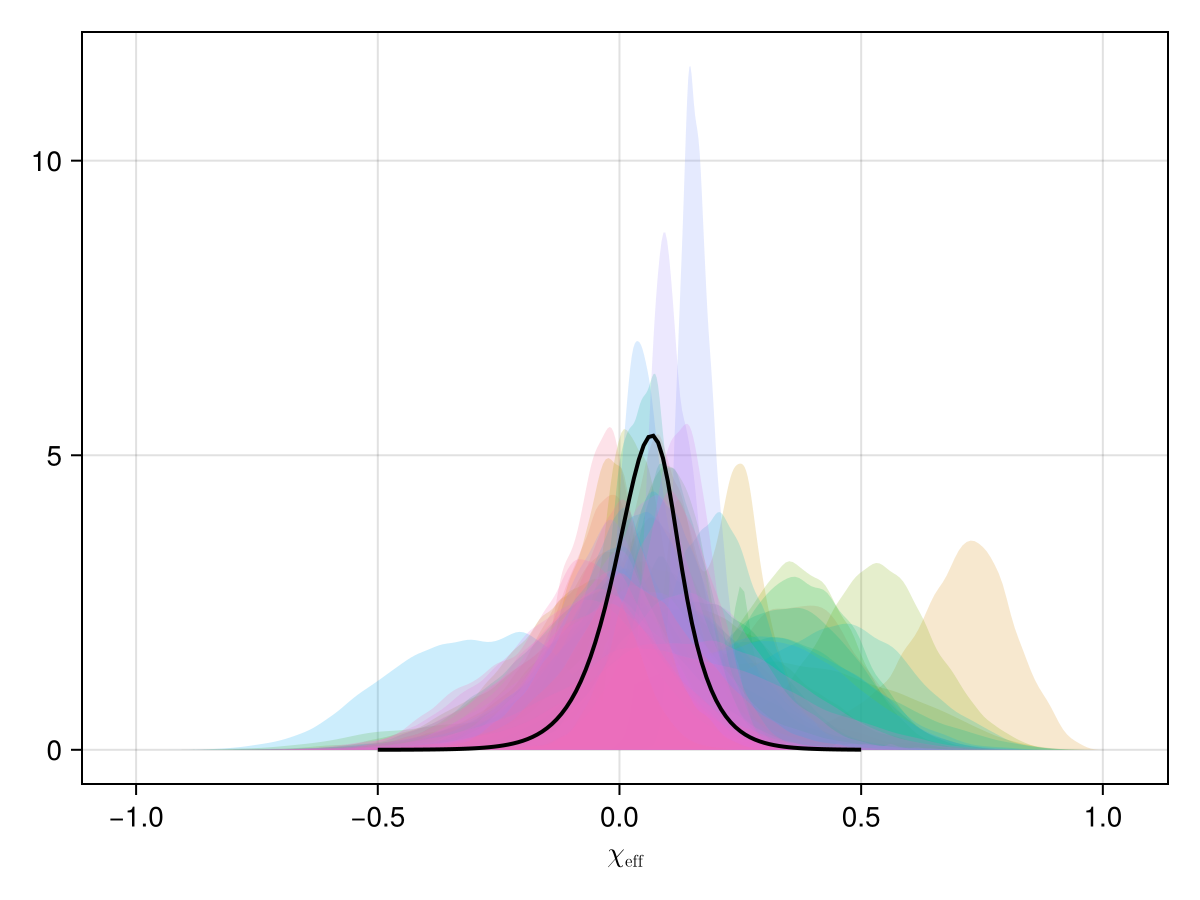

In [15]:
cs = categorical_palette(nevt)

f = Figure()
a = Axis(f[1,1], xlabel=L"\chi_\mathrm{eff}")

for (i, evt) in enumerate(groupby(bbh_events, :gwname))
    density!(a, evt[!, :chi_eff], color=(cs[i], 0.2)) # color and alpha = 0.2
end

chies = -0.5:0.01:0.5
p_chies = [pdf.((Normal(mu, sigma),), chies) for (mu, sigma) in zip(gp_trace.posterior.mu, gp_trace.posterior.sigma)]
p_chie = mean(p_chies)
lines!(a, chies, p_chie, color=:black, linewidth=2)

f

It looks like there are a couple of outliers that it might be worth following up on....

One final thing we can do is to extend our population model to reproduce some of the results in [Callister, et. al (2020)](https://ui.adsabs.harvard.edu/abs/2021ApJ...922L...5C/abstract) (the "Who Ordered That") paper.  In that model, we assumed a joint population on $q$ and $\chi_\mathrm{eff}$ with 
$$
p\left( q, \chi_\mathrm{eff} \right) = N\left[ \mu(q), \sigma \right]\left( \chi_\mathrm{eff} \right) q^\alpha,
$$
where $\mu(q) = \mu_0 (1-q) + \mu_1 q$ is a linear function of the mass ratio.  (Actually we *also* assumed a linear relation for $\log \sigma$ with $q$, but I'm going to leave that out to keep things simple.)  In code:

In [17]:
# Add some columns to the detected injections for the constant part of the population (draw weights are already computed; see `load_selection`):
detected_injections[!, :mass_1_source] = detected_injections[!, :mass1_source]
detected_injections[!, :pop_logwt_m1qz] = pop_logwt_m1qz(detected_injections)
detected_injections[!, :log_sampling_pdf_qchieff] = log.(detected_injections[!, :sampling_pdf_qchieff])

Nsamp = 256
bbh_df = vcat([df[rand(1:size(df,1), Nsamp), :] for df in groupby(bbh_events, :gwname)]...; cols=:intersect)

@model function wot_pop(catalog_df, detected_df)
    mu_0 ~ Normal(0, 1) # Pretty broad prior on the mean of the distribution at q = 0
    mu_1 ~ Normal(0, 1) # Pretty broad prior on the mean of the distribution at q = 1
    sigma ~ Exponential(1) # Pretty broad prior on the standard deviation of the distribution

    alpha_q ~ Uniform(-2, 2) # Power law exponent of mass ratio, constrained to be between -2 to 2

    log_popwt = (q, chie) -> alpha_q * log(q) + logpdf(Normal(mu_0 * (1-q) + mu_1 * q, sigma), chie)

    # Estimate alpha, the selection correction:
    log_alpha_wts = log_popwt.(detected_df[!, :q], detected_df[!, :chi_eff]) .+ detected_df[!, :pop_logwt_m1qz] .- detected_df[!, :log_sampling_pdf_qchieff]
    log_alpha = logsumexp(log_alpha_wts)

    for evt in groupby(catalog_df, :gwname)
        log_wt = log_popwt.(evt[!, :mass_ratio], evt[!, :chi_eff]) .+ evt[!, :pop_logwt_m1qz] .- evt[!, :pe_logwt_m1qzchie]
        @Turing.addlogprob! logsumexp(log_wt) - log_alpha
    end
end

wot_model = wot_pop(bbh_df, detected_injections)
wot_trace_mcmcchains = sample(wot_model, NUTS(Nmcmc, 0.65), Nmcmc)
wot_trace = from_mcmcchains(wot_trace_mcmcchains) # Convert to ArviZ object

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /Users/wfarr/.julia/packages/Turing/nQwbh/src/mcmc/hmc.jl:207
Sampling   0%|▎                                         |  ETA: 0:38:34
Sampling   1%|▍                                         |  ETA: 0:33:45
Sampling   2%|▋                                         |  ETA: 0:33:41
Sampling   2%|▉                                         |  ETA: 16:55:56
Sampling   2%|█                                         |  ETA: 1 days, 5:18:29
Sampling   3%|█▎                                        |  ETA: 1 days, 0:26:09
Sampling   4%|█▌                                        |  ETA: 21:03:03
Sampling   4%|█▋                                        |  ETA: 18:27:02
Sampling   4%|█▉                                        |  ETA: 16:25:37
Sampling   5%|██▏                                       |  ETA: 14:47:56
Sampling   6%|██▎                                       |  ETA: 

InferenceData with groups:
  > posterior
  > sample_stats

The trace looks pretty reasonable here:

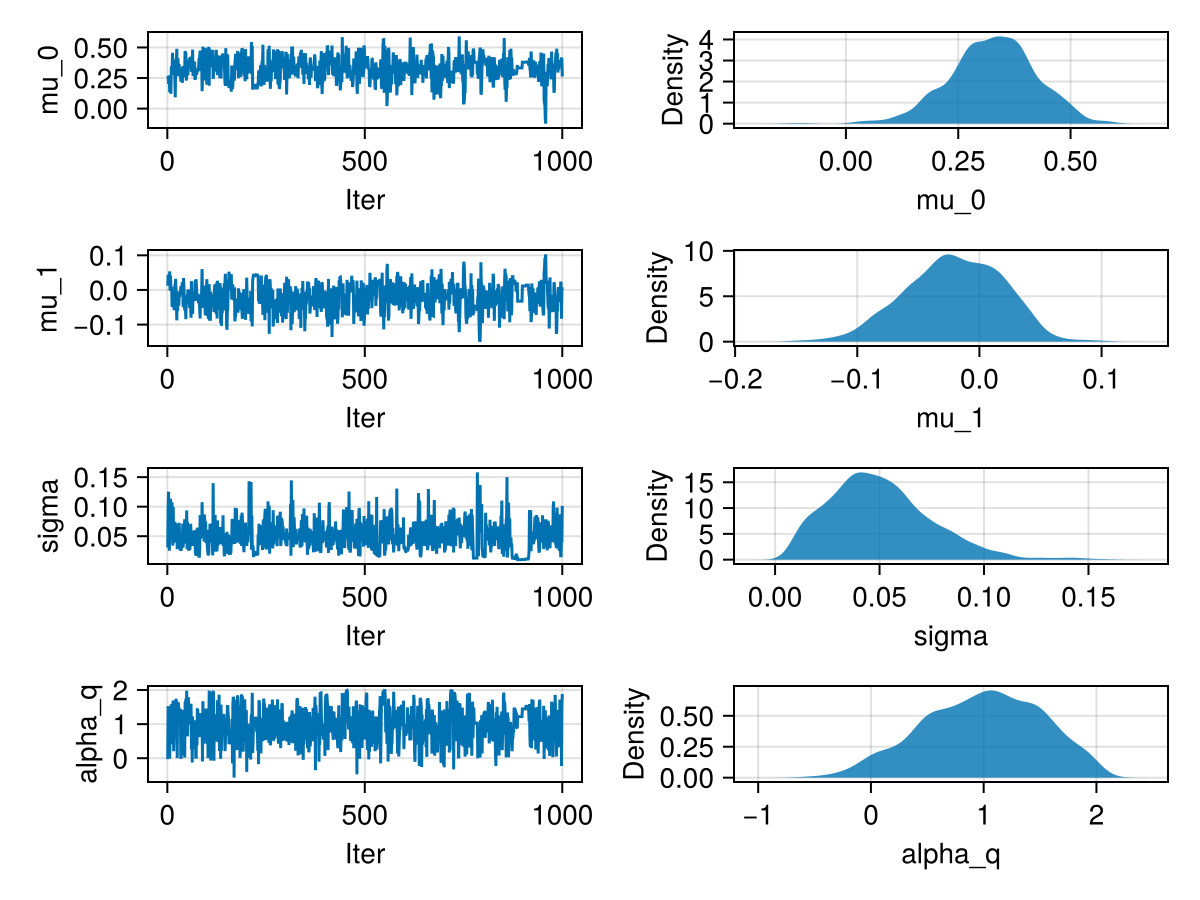

In [18]:
SelectionTutorial.traceplot(wot_trace, [:mu_0, :mu_1, :sigma, :alpha_q])

A key quantity was the slope of the mean $\chi_\mathrm{eff}$ with $q$, which in our model is 
$$
\frac{\mathrm{d} \left\langle \chi_\mathrm{eff} \mid q \right\rangle}{\mathrm{d} q} = \mu_1 - \mu_0.
$$
Like in "Who Ordered That," we find that this quantity is confiently less than zero:

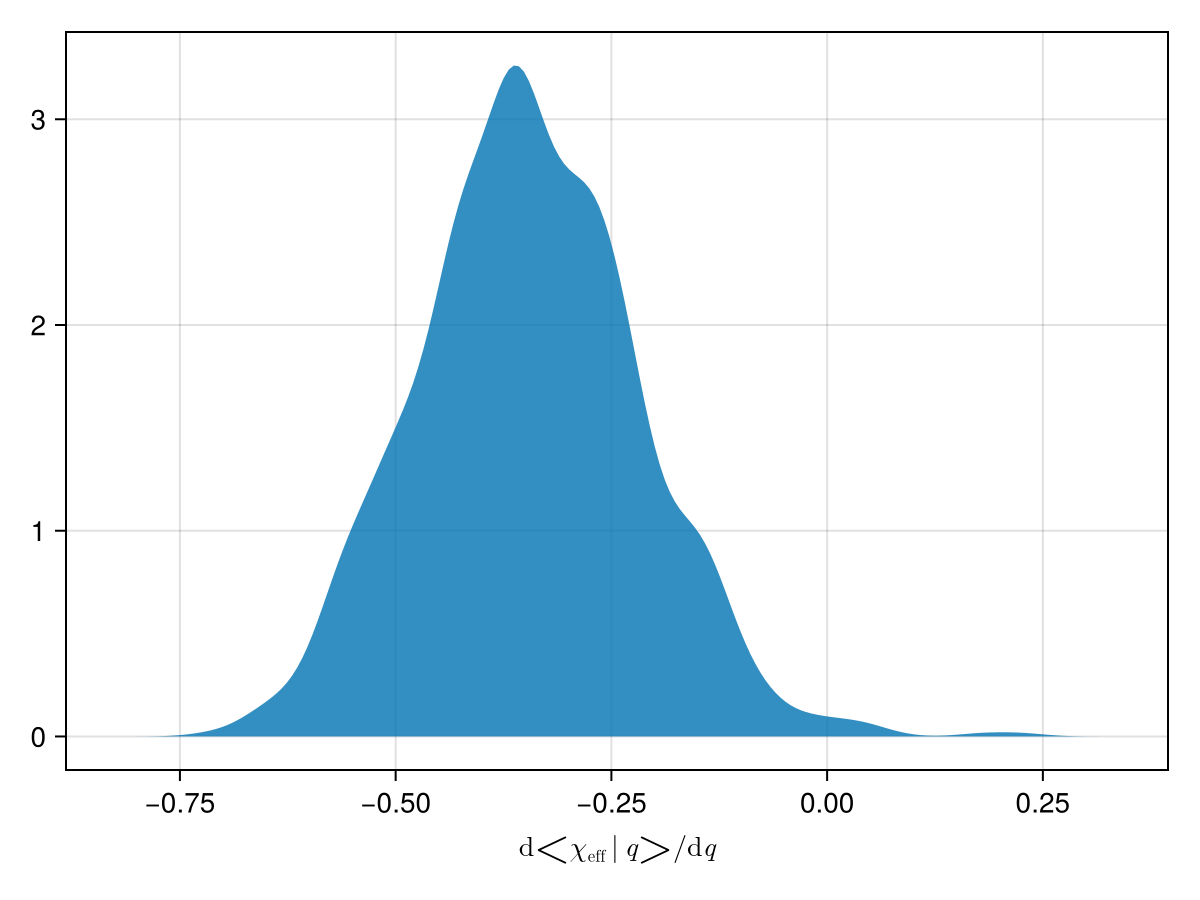

In [19]:
f = Figure()
a = Axis(f[1,1], xlabel=L"\mathrm{d} \left< \chi_\mathrm{eff} \mid q \right> / \mathrm{d} q")
density!(a, vec(wot_trace.posterior.mu_1 .- wot_trace.posterior.mu_0))
f

A final plot, showing the 2D contours of each event (the 90% contour) in $q$-$\chi_\mathrm{eff}$ using the PE priors, and our fitted distribution:

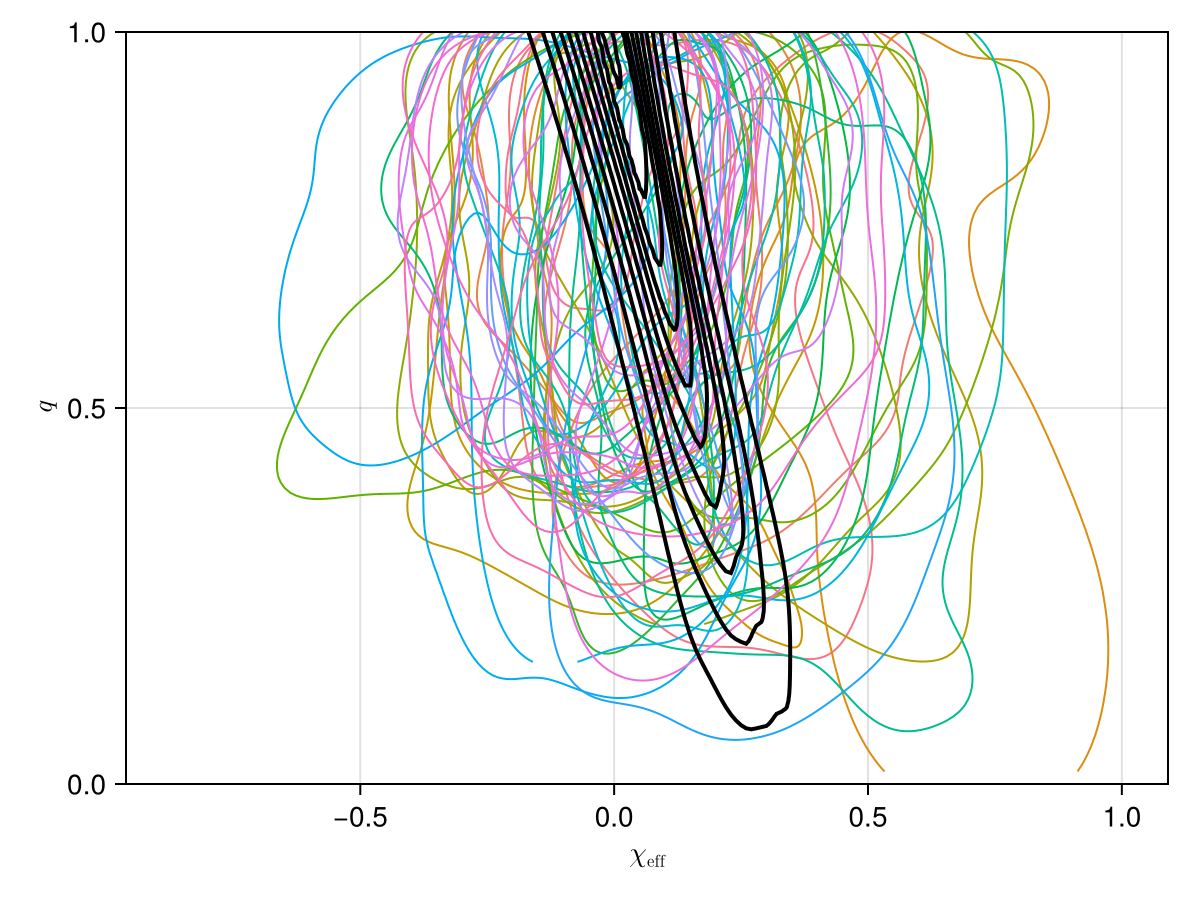

In [20]:
cs = categorical_palette(nevt)

f = Figure()
a = Axis(f[1,1], xlabel=L"\chi_\mathrm{eff}", ylabel=L"q", limits=(nothing, nothing, 0, 1))

for (i, evt) in enumerate(groupby(bbh_events, :gwname))
    df = evt[rand(1:size(evt,1), 256), :]
    kdecontour!(a, df[!, :chi_eff], df[!, :mass_ratio], levels=[0.1], color=cs[i])
end

qs = 0.01:0.01:1.0
chieffs = -0.5:0.01:0.5
p_chieffs = []
for (mu_0, mu_1, sigma, alpha_q) in zip(wot_trace.posterior.mu_0, wot_trace.posterior.mu_1, wot_trace.posterior.sigma, wot_trace.posterior.alpha_q)
    pop_wt = (q, chie) -> q^alpha_q * pdf(Normal(mu_0 * (1-q) + mu_1 * q, sigma), chie)
    pop = [pop_wt(q, chie) for chie in chieffs, q in qs]
    pop = pop ./ sum(pop) # sum to 1 (sum is proportional to the integral, since the grid has constant spacing)
    push!(p_chieffs, pop)
end
mean_pop = mean(p_chieffs)
mean_pop = mean_pop ./ sum(mean_pop) # This should be unnecessary, but just in case, normalize

p_sorted = sort(vec(mean_pop)) # small to large
c_sorted = cumsum(p_sorted) # cumulative sum from small to large
cls = [p_sorted[argmin(abs.(c_sorted .- l))] for l in 0.1 * (1:9)]

contour!(chieffs, qs, mean_pop, levels=cls, color=:black, linewidth=2)

f

Things to do:

* Optimize the models (see, in particular, the type stability instructions [here](https://turinglang.org/docs/usage/performance-tips/))!
* Use the fact that we can do Gaussian integrals, and we can fit KDEs to the PE samples and also to the detected injections to *analytically* marginalize out the $\chi_\mathrm{eff}$ population (this solves some instabilities as $\sigma \to 0$ in the Monte-Carlo integral over samples).
* Adapt to use [`PopModels.jl`](https://github.com/farr/PopModels.jl) to do the fitting.
* Add a model for the mass, and fit that too.
* Add a model for the redshift, and fit that too.
* Allow the width of the $\chi_\mathrm{eff}$ distribution to depend on $q$ as well.
* Look into the outliers, and see which events are driving the correlation.
* ...